In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statistics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.inspection import permutation_importance
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import matthews_corrcoef
import shap
import statsmodels.api as sm
from sklearn.feature_selection import chi2, f_classif
from sklearn.calibration import calibration_curve
from scipy.stats import wilcoxon
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import statsmodels.stats.multitest as multitest

In [2]:
nacc_data = pd.read_csv('NACC_final_04_09_2020.csv')
nacc_data = nacc_data.dropna()
nacc_data = nacc_data[nacc_data.NACCUDSD != "CN"]

In [3]:
nacc_data

,NACCID,NACCVNUM,NACCETPR,NACCUDSD,BILLS,TAXES,SHOPPING,GAMES,STOVE,MEALPREP,EVENTS,PAYATTN,REMDATES,TRAVEL,SEX,RACE,MARISTAT,EDUC,NACCAGE
0,NACC003204,2,1,MCI,1,1,1,0,0,1,2,1,1,1,1,1,1,14,79
1,NACC004558,2,1,MCI,0,0,0,0,0,0,0,0,0,0,1,2,1,12,82
2,NACC005334,1,1,MCI,0,0,0,0,0,0,1,0,1,0,2,1,3,14,80
3,NACC005498,1,1,MCI,0,0,0,0,0,0,0,0,0,0,2,1,2,12,89
4,NACC006823,6,1,MCI,2,3,0,1,0,0,0,0,0,0,2,1,1,14,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835,NACC997015,5,1,AD,2,2,1,0,0,2,1,0,2,1,2,1,1,14,74
1836,NACC997165,10,1,AD,3,3,2,1,0,0,1,1,2,2,2,1,2,18,92
1837,NACC998350,6,1,AD,3,3,2,3,2,2,3,1,3,3,2,2,3,16,76
1838,NACC998489,7,1,AD,2,2,1,0,0,1,1,1,1,0,2,1,3,18,77


## Splitting

In [4]:
x_faq = nacc_data.filter(items = ["BILLS","TAXES","SHOPPING","GAMES","STOVE","MEALPREP","EVENTS","PAYATTN",
                                  "REMDATES","TRAVEL"]).values
x_total = nacc_data.filter(items = ["BILLS","TAXES","SHOPPING","GAMES","STOVE","MEALPREP","EVENTS","PAYATTN",
                                  "REMDATES","TRAVEL","SEX","RACE","MARISTAT","EDUC","NACCAGE"]).values
y = nacc_data.filter(items = ["NACCUDSD"]).values

## Encoding

In [5]:
nacc_le = LabelEncoder()
y = nacc_le.fit_transform(y)
y

/Users/maborageh/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([1, 1, 1, ..., 0, 0, 0])

## Random Forest

In [8]:
RF = RandomForestClassifier(random_state = 1)

In [9]:
p_grid = {"n_estimators" : [100,300,500,800],
         "min_samples_split" : [2,5,10,15],
         "min_samples_leaf" : [1, 2, 5, 10]}

In [8]:
clf = GridSearchCV(estimator = RF, param_grid = p_grid, cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
clf_fit = clf.fit(x_faq,y).predict_proba(x_faq)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.0min finished


In [9]:
feature_importances = permutation_importance(clf, x_faq, y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [10]:
feature_names_faq = ["BILLS","TAXES","SHOPPING","GAMES","STOVE","MEALPREP","EVENTS","PAYATTN",
                                  "REMDATES","TRAVEL"]
indices = np.argsort(feature_importances.importances_mean)[::-1]
scores = []
ticks = []
for i in indices:
    scores.append(feature_importances.importances_mean[i])
    ticks.append(feature_names_faq[i])
    print("{}: {:.3f}".format(feature_names_faq[i], feature_importances.importances_mean[i]))

TRAVEL: 0.026
TAXES: 0.026
BILLS: 0.024
MEALPREP: 0.019
EVENTS: 0.019
SHOPPING: 0.014
REMDATES: 0.014
PAYATTN: 0.010
GAMES: 0.010
STOVE: 0.004


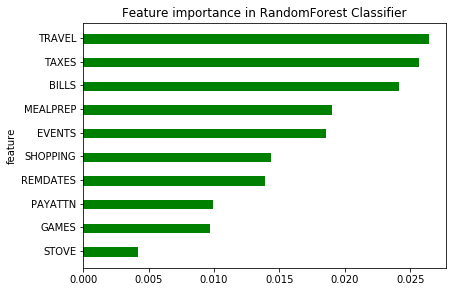

<Figure size 360x360 with 0 Axes>

In [11]:
fig, ax = plt.subplots() 
width = 0.4
ind = np.arange(len(scores))
ax.barh(ind, scores[::-1], width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(ticks[::-1], minor=False)
plt.title("Feature importance in RandomForest Classifier")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

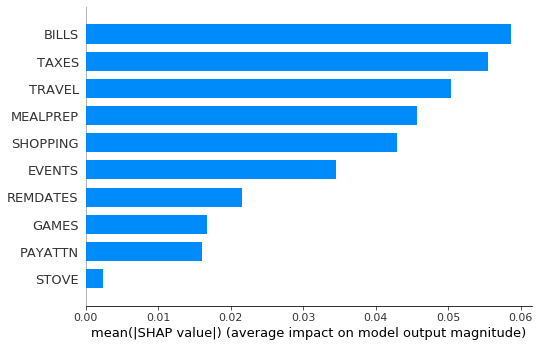

In [12]:
shap_values = shap.TreeExplainer(clf.best_estimator_).shap_values(x_faq)
shap.summary_plot(shap_values[0], x_faq,feature_names = feature_names_faq,plot_type = "bar")

## Gradient Boosting

In [10]:
GB = GradientBoostingClassifier(random_state = 1)

In [11]:
gb_grid = {"n_estimators" : [100,300,500,800],
         "min_samples_split" : [2,5,10,15],
         "min_samples_leaf" : [1,2,5,10],
          "learning_rate": [0.01,0.05,0.1]}

In [15]:
gbf = GridSearchCV(estimator = GB, param_grid = gb_grid, cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
gbf_fit = gbf.fit(x_faq,y)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  3.7min finished


In [16]:
gb_feature_importances = permutation_importance(gbf_fit, x_faq, y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [17]:
feature_names_faq = ["BILLS","TAXES","SHOPPING","GAMES","STOVE","MEALPREP","EVENTS","PAYATTN",
                                  "REMDATES","TRAVEL"]
gb_indices = np.argsort(gb_feature_importances.importances_mean)[::-1]
scores = []
ticks = []
for i in gb_indices:
    scores.append(gb_feature_importances.importances_mean[i])
    ticks.append(feature_names_faq[i])
    print("{}: {:.3f}".format(feature_names_faq[i], gb_feature_importances.importances_mean[i]))

BILLS: 0.031
TRAVEL: 0.022
TAXES: 0.019
REMDATES: 0.015
EVENTS: 0.015
MEALPREP: 0.013
SHOPPING: 0.010
GAMES: 0.005
PAYATTN: 0.002
STOVE: 0.001


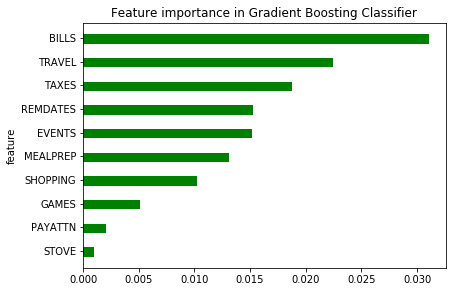

<Figure size 360x360 with 0 Axes>

In [18]:
fig, ax = plt.subplots() 
width = 0.4
ind = np.arange(len(scores))
ax.barh(ind, scores[::-1], width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(ticks[::-1], minor=False)
plt.title("Feature importance in Gradient Boosting Classifier")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

In [19]:
gb_shap_values = shap.TreeExplainer(gbf.best_estimator_).shap_values(x_faq)

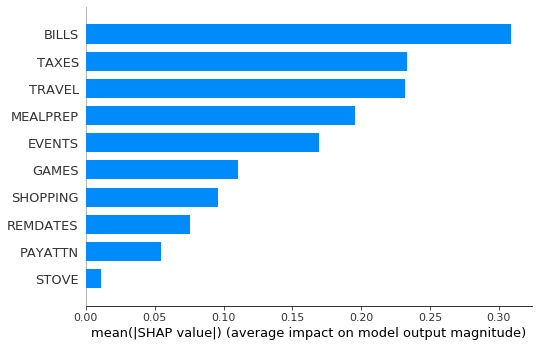

In [20]:
shap.summary_plot(gb_shap_values, x_faq,feature_names = feature_names_faq,plot_type = "bar")

## Logistic Regression

In [12]:
LR = LogisticRegression()

In [13]:
lr_grid = {"penalty":["l1","l2"],
          "C":np.logspace(-4,4,20),
          "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          "max_iter":[100,1000,2500,5000]}

In [23]:
lrf = GridSearchCV(estimator = LR, param_grid = lr_grid, cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
lrf_fit = lrf.fit(x_faq,y)

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:    8.4s finished


In [24]:
lr_feature_importances = permutation_importance(lrf_fit, x_faq, y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [25]:
feature_names_faq = ["BILLS","TAXES","SHOPPING","GAMES","STOVE","MEALPREP","EVENTS","PAYATTN",
                                  "REMDATES","TRAVEL"]
lr_indices = np.argsort(lr_feature_importances.importances_mean)[::-1]
scores = []
ticks = []
for i in gb_indices:
    scores.append(lr_feature_importances.importances_mean[i])
    ticks.append(feature_names_faq[i])
    print("{}: {:.3f}".format(feature_names_faq[i], lr_feature_importances.importances_mean[i]))

BILLS: 0.011
TRAVEL: 0.010
TAXES: 0.012
REMDATES: 0.002
EVENTS: 0.007
MEALPREP: 0.004
SHOPPING: 0.001
GAMES: 0.001
PAYATTN: 0.001
STOVE: -0.000


## Nested Cross Validation

In [37]:
outer_cv = 10

#Metrics to calculate

specificity = make_scorer(recall_score, pos_label=0)
sensitivity = make_scorer(recall_score, pos_label=1)
mcc = make_scorer(matthews_corrcoef)

s_dict = {"specificity" : make_scorer(recall_score, pos_label=0),
         "sensitivity" : make_scorer(recall_score, pos_label=1),
         "mcc":make_scorer(matthews_corrcoef)}

scores = {'accuracy' : 'accuracy',
         'precision' : 'precision',
          "roc":'roc_auc',
          "balanced_acc":"balanced_accuracy",
         "specificity" : s_dict["specificity"],
         "sensitivity" : s_dict["sensitivity"],
         "MCC":s_dict["mcc"],
         "f1_score":"f1"}

In [28]:
rf_class_probabilities = cross_val_predict(estimator = clf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/maborageh/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 16.5min remaining: 11.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 25.7min finished


In [29]:
gb_class_probabilities = cross_val_predict(estimator = gbf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 32.2min remaining: 21.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 52.3min finished


In [30]:
lr_class_probabilities = cross_val_predict(estimator = lrf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.2min remaining:   46.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


In [31]:
rf_proba = rf_class_probabilities[:,1]

rf_fraction_of_positives, rf_mean_predicted_value = calibration_curve(y, rf_proba, n_bins=10)

In [32]:
gb_proba = gb_class_probabilities[:,1]

gb_fraction_of_positives, gb_mean_predicted_value = calibration_curve(y, gb_proba, n_bins=10)

In [33]:
lr_proba = lr_class_probabilities[:,1]

lr_fraction_of_positives, lr_mean_predicted_value = calibration_curve(y, lr_proba, n_bins=10)

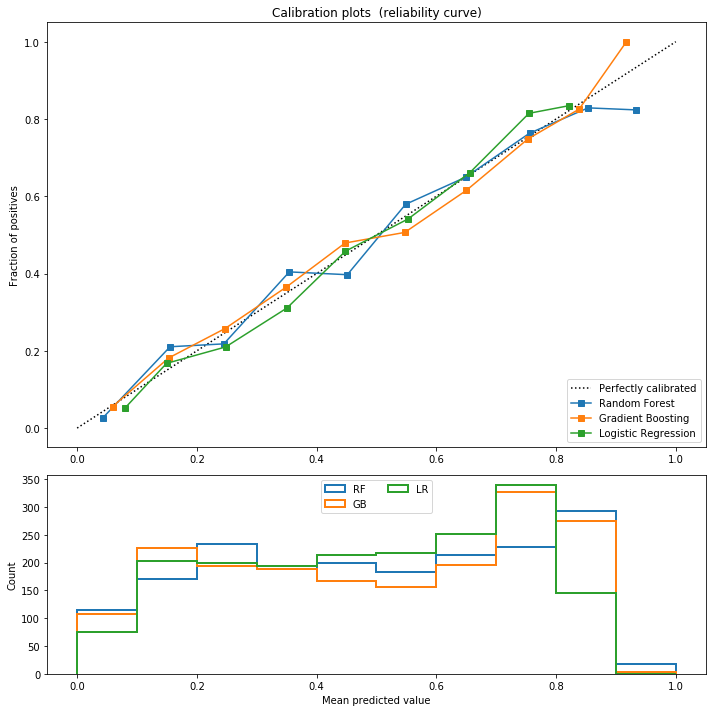

In [34]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(rf_mean_predicted_value, rf_fraction_of_positives, "s-",
             label="%s" % ("Random Forest", ))
ax1.plot(gb_mean_predicted_value, gb_fraction_of_positives, "s-",
             label="%s" % ("Gradient Boosting", ))
ax1.plot(lr_mean_predicted_value, lr_fraction_of_positives, "s-",
             label="%s" % ("Logistic Regression", ))


ax2.hist(rf_proba, range=(0, 1), bins=10, label="RF",
             histtype="step", lw=2)
ax2.hist(gb_proba, range=(0, 1), bins=10, label="GB",
             histtype="step", lw=2)
ax2.hist(lr_proba, range=(0, 1), bins=10, label="LR",
             histtype="step", lw=2)
    
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [35]:
rf_nested_scores = cross_validate(estimator = clf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 16.6min remaining: 11.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 25.7min finished


In [36]:
gb_nested_scores = cross_validate(estimator = gbf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 32.1min remaining: 21.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 52.2min finished


In [37]:
lr_nested_scores = cross_validate(estimator = lrf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.1min remaining:   45.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.6min finished


In [38]:
print("Accuracy:", statistics.mean(rf_nested_scores['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(rf_nested_scores['test_balanced_acc']))
print("Precision:", statistics.mean(rf_nested_scores['test_precision']))
print("Specificity:", statistics.mean(rf_nested_scores['test_specificity']))
print("Sensitivity:", statistics.mean(rf_nested_scores['test_sensitivity']))
print("Matthews Correlation Coefficient:", statistics.mean(rf_nested_scores['test_MCC']))
print("F1 Score:", statistics.mean(rf_nested_scores['test_f1_score']))
print("ROC:", statistics.mean(rf_nested_scores['test_roc']))

Accuracy: 0.7260869565217392
Balanced Accuracy: 0.7260869565217392
Precision: 0.7234403861289712
Specificity: 0.7184782608695652
Sensitivity: 0.7336956521739131
Matthews Correlation Coefficient: 0.4528725554154502
F1 Score: 0.7280347015971967
ROC: 0.7919482514177694


In [39]:
print("Accuracy:", statistics.mean(gb_nested_scores['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(gb_nested_scores['test_balanced_acc']))
print("Precision:", statistics.mean(gb_nested_scores['test_precision']))
print("Sensitivity:", statistics.mean(gb_nested_scores['test_sensitivity']))
print("Specificity:", statistics.mean(gb_nested_scores['test_specificity']))
print("Matthews Correlation Coefficient:", statistics.mean(gb_nested_scores['test_MCC']))
print("F1 Score:", statistics.mean(gb_nested_scores['test_f1_score']))
print("ROC", statistics.mean(gb_nested_scores['test_roc']))

Accuracy: 0.7130434782608696
Balanced Accuracy: 0.7130434782608696
Precision: 0.7052695664983877
Sensitivity: 0.7326086956521739
Specificity: 0.6934782608695652
Matthews Correlation Coefficient: 0.42687577995924003
F1 Score: 0.7183454349045308
ROC 0.7891776937618147


In [40]:
print("Accuracy:", statistics.mean(lr_nested_scores['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(lr_nested_scores['test_balanced_acc']))
print("Precision:", statistics.mean(lr_nested_scores['test_precision']))
print("Sensitivity:", statistics.mean(lr_nested_scores['test_sensitivity']))
print("Specificity:", statistics.mean(lr_nested_scores['test_specificity']))
print("Matthews Correlation Coefficient:", statistics.mean(lr_nested_scores['test_MCC']))
print("F1 Score:", statistics.mean(lr_nested_scores['test_f1_score']))
print("ROC", statistics.mean(lr_nested_scores['test_roc']))

Accuracy: 0.7228260869565217
Balanced Accuracy: 0.7228260869565217
Precision: 0.7159557815227422
Sensitivity: 0.741304347826087
Specificity: 0.7043478260869565
Matthews Correlation Coefficient: 0.44657598045477437
F1 Score: 0.7279173154143961
ROC 0.7936968336483932


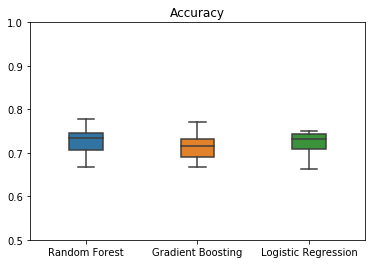

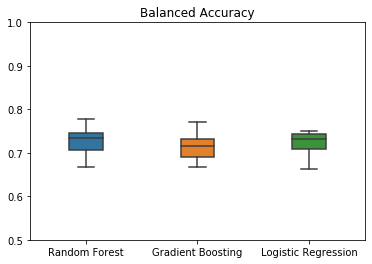

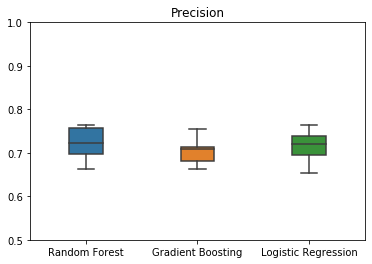

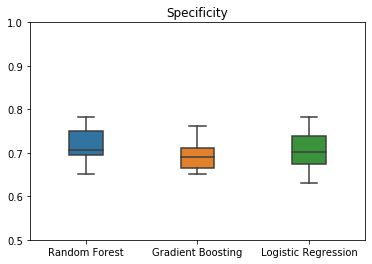

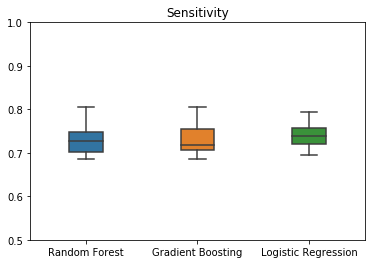

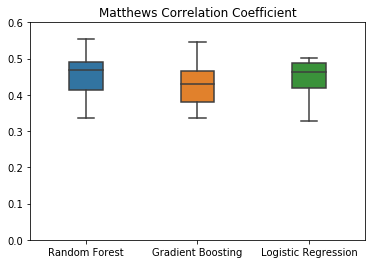

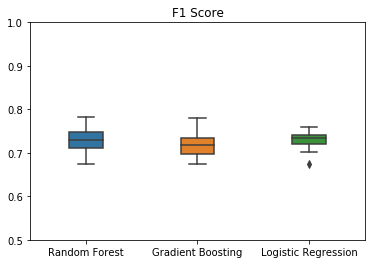

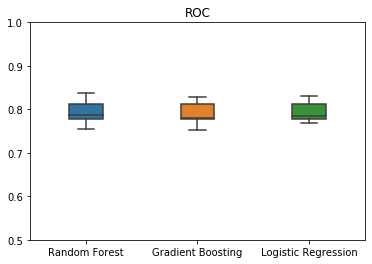

In [41]:
rf_acc = rf_nested_scores['test_accuracy']
gb_acc = gb_nested_scores['test_accuracy']
lr_acc = lr_nested_scores['test_accuracy']
sns.boxplot(data = [rf_acc,gb_acc,lr_acc], width = 0.3).set_title("Accuracy")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_ba_acc = rf_nested_scores['test_balanced_acc']
gb_ba_acc = gb_nested_scores['test_balanced_acc']
lr_ba_acc = lr_nested_scores['test_balanced_acc']
sns.boxplot(data = [rf_ba_acc,gb_ba_acc,lr_ba_acc], width = 0.3).set_title("Balanced Accuracy")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_precision = rf_nested_scores['test_precision']
gb_precision = gb_nested_scores['test_precision']
lr_precision = lr_nested_scores['test_precision']
sns.boxplot(data = [rf_precision,gb_precision,lr_precision], width = 0.3).set_title("Precision")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_spec = rf_nested_scores['test_specificity']
gb_spec = gb_nested_scores['test_specificity']
lr_spec = lr_nested_scores['test_specificity']
sns.boxplot(data = [rf_spec,gb_spec,lr_spec], width = 0.3).set_title("Specificity")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_sens = rf_nested_scores['test_sensitivity']
gb_sens = gb_nested_scores['test_sensitivity']
lr_sens = lr_nested_scores['test_sensitivity']
sns.boxplot(data = [rf_sens,gb_sens,lr_sens], width = 0.3).set_title("Sensitivity")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_mcc = rf_nested_scores['test_MCC']
gb_mcc = gb_nested_scores['test_MCC']
lr_mcc = lr_nested_scores['test_MCC']
sns.boxplot(data = [rf_mcc,gb_mcc,lr_mcc], width = 0.3).set_title("Matthews Correlation Coefficient")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0,0.6)
plt.show()

rf_f1 = rf_nested_scores['test_f1_score']
gb_f1 = gb_nested_scores['test_f1_score']
lr_f1 = lr_nested_scores['test_f1_score']
sns.boxplot(data = [rf_f1,gb_f1,lr_f1], width = 0.3).set_title("F1 Score")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_roc = rf_nested_scores['test_roc']
gb_roc = gb_nested_scores['test_roc']
lr_roc = lr_nested_scores['test_roc']
sns.boxplot(data = [rf_roc,gb_roc,lr_roc], width = 0.3).set_title("ROC")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

## Model Implementation with FAQ & Demographic information

### Random Forest

In [55]:
clf_total = GridSearchCV(estimator = RF, param_grid = p_grid,
                         cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
clf_total_fit = clf_total.fit(x_total,y)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.1min finished


In [56]:
feature_importances_total = permutation_importance(clf_total_fit, x_total,
                                                   y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [57]:
feature_names_total = ["BILLS","TAXES","SHOPPING","GAMES","STOVE","MEALPREP","EVENTS","PAYATTN",
                                  "REMDATES","TRAVEL","SEX","RACE","MARISTAT","EDUC","NACCAGE"]
indices_total = np.argsort(feature_importances_total.importances_mean)[::-1]
scores = []
ticks = []
for i in indices_total:
    scores.append(feature_importances_total.importances_mean[i])
    ticks.append(feature_names_total[i])
    print("{}: {:.3f}".format(feature_names_total[i], feature_importances_total.importances_mean[i]))

TAXES: 0.026
BILLS: 0.025
TRAVEL: 0.023
MEALPREP: 0.019
EVENTS: 0.017
NACCAGE: 0.017
SHOPPING: 0.016
REMDATES: 0.013
EDUC: 0.010
PAYATTN: 0.010
GAMES: 0.009
SEX: 0.007
MARISTAT: 0.006
STOVE: 0.003
RACE: 0.002


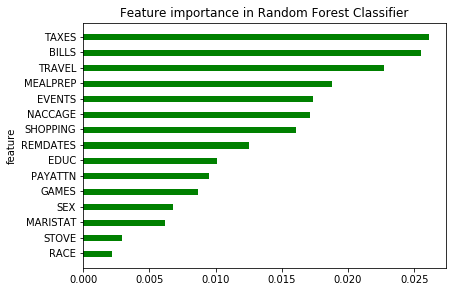

<Figure size 360x360 with 0 Axes>

In [58]:
fig, ax = plt.subplots() 
width = 0.4
ind = np.arange(len(scores))
ax.barh(ind, scores[::-1], width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(ticks[::-1], minor=False)
plt.title("Feature importance in Random Forest Classifier")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

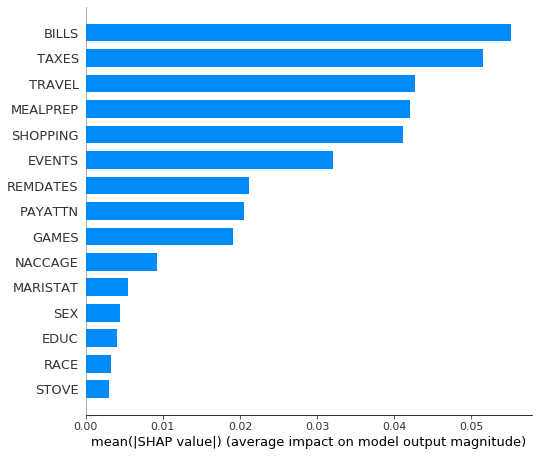

In [59]:
shap_values = shap.TreeExplainer(clf_total.best_estimator_).shap_values(x_total)
shap.summary_plot(shap_values[0], x_total,feature_names = feature_names_total,plot_type = "bar")

### Gradient Boosting

In [60]:
gbf_total = GridSearchCV(estimator = GB, param_grid = gb_grid,
                   cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
gbf_total_fit = gbf_total.fit(x_total,y)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  4.8min finished


In [61]:
gb_feature_importances_total = permutation_importance(gbf_total_fit, x_total, y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [62]:
feature_names_total = ["BILLS","TAXES","SHOPPING","GAMES","STOVE","MEALPREP","EVENTS","PAYATTN",
                                  "REMDATES","TRAVEL","SEX","RACE","MARISTAT","EDUC","NACCAGE"]
gb_indices_total = np.argsort(gb_feature_importances_total.importances_mean)[::-1]
scores = []
ticks = []
for i in gb_indices_total:
    scores.append(gb_feature_importances_total.importances_mean[i])
    ticks.append(feature_names_total[i])
    print("{}: {:.3f}".format(feature_names_total[i], gb_feature_importances_total.importances_mean[i]))

BILLS: 0.025
TRAVEL: 0.023
TAXES: 0.021
EVENTS: 0.015
MEALPREP: 0.013
REMDATES: 0.012
NACCAGE: 0.011
SHOPPING: 0.008
MARISTAT: 0.007
GAMES: 0.005
SEX: 0.004
PAYATTN: 0.003
RACE: 0.002
EDUC: 0.002
STOVE: 0.001


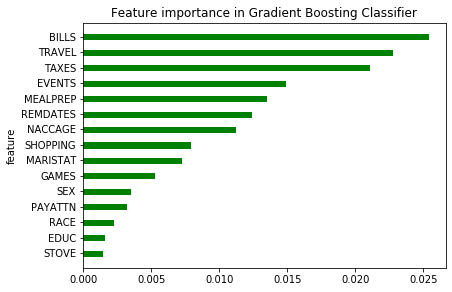

<Figure size 360x360 with 0 Axes>

In [63]:
fig, ax = plt.subplots() 
width = 0.4
ind = np.arange(len(scores))
ax.barh(ind, scores[::-1], width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(ticks[::-1], minor=False)
plt.title("Feature importance in Gradient Boosting Classifier")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

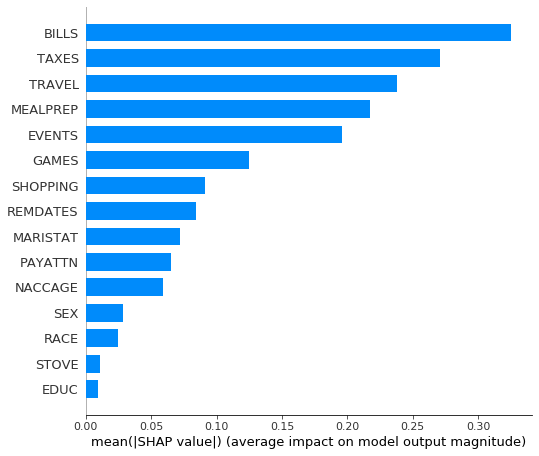

In [64]:
gb_shap_values = shap.TreeExplainer(gbf_total.best_estimator_).shap_values(x_total)
shap.summary_plot(gb_shap_values, x_total,feature_names = feature_names_total,plot_type = "bar")

## Logistic Regression

In [65]:
lr_grid_2 = {"penalty":["l1","l2"],
          "C":np.logspace(-4,4,20),
          "solver":['newton-cg', 'lbfgs','sag', 'saga'],
          "max_iter":[8000,10000]}
lrf_total = GridSearchCV(estimator = LR, param_grid = lr_grid_2,
                   cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
lrf_total_fit = lrf_total.fit(x_total,y)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 1554 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 2913 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:  2.2min finished


In [66]:
lr_feature_importances_total = permutation_importance(lrf_total_fit, x_total,
                                                      y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [67]:
feature_names_total = ["BILLS","TAXES","SHOPPING","GAMES","STOVE","MEALPREP","EVENTS","PAYATTN",
                                  "REMDATES","TRAVEL","SEX","RACE","MARISTAT","EDUC","NACCAGE"]
lr_indices_total = np.argsort(lr_feature_importances_total.importances_mean)[::-1]
scores = []
ticks = []
for i in lr_indices_total:
    scores.append(lr_feature_importances_total.importances_mean[i])
    ticks.append(feature_names_total[i])
    print("{}: {:.3f}".format(feature_names_total[i], lr_feature_importances_total.importances_mean[i]))

TAXES: 0.014
BILLS: 0.011
TRAVEL: 0.009
EVENTS: 0.008
MEALPREP: 0.004
REMDATES: 0.002
MARISTAT: 0.002
GAMES: 0.001
SHOPPING: 0.001
PAYATTN: 0.001
NACCAGE: 0.001
EDUC: 0.000
RACE: 0.000
SEX: 0.000
STOVE: -0.000


## Nested Cross Validation

In [16]:
rf_class_probabilities_total = cross_val_predict(estimator = clf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/maborageh/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 17.4min remaining: 11.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 26.6min finished


In [31]:
gb_class_probabilities_total = cross_val_predict(estimator = gbf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 38.7min remaining: 25.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 59.9min finished


In [22]:
lr_class_probabilities_total = cross_val_predict(estimator = lrf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  8.7min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.5min finished


In [32]:
rf_proba_total = rf_class_probabilities_total[:,1]

rf_fraction_of_positives_total, rf_mean_predicted_value_total = calibration_curve(y, rf_proba_total, n_bins=10)

In [33]:
gb_proba_total = gb_class_probabilities_total[:,1]

gb_fraction_of_positives_total, gb_mean_predicted_value_total = calibration_curve(y, gb_proba_total, n_bins=10)

In [34]:
lr_proba_total = lr_class_probabilities_total[:,1]

lr_fraction_of_positives_total, lr_mean_predicted_value_total = calibration_curve(y, lr_proba_total, n_bins=10)

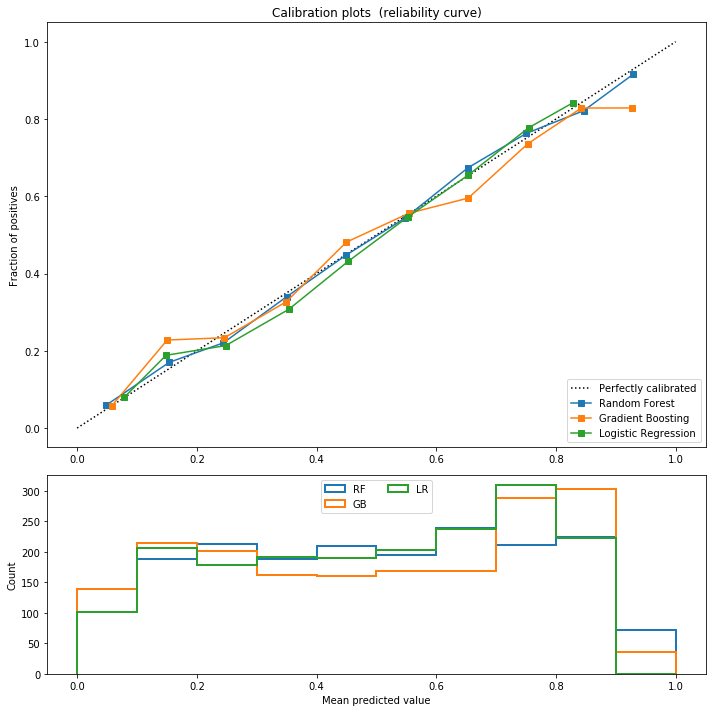

In [35]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(rf_mean_predicted_value_total, rf_fraction_of_positives_total, "s-",
             label="%s" % ("Random Forest", ))
ax1.plot(gb_mean_predicted_value_total, gb_fraction_of_positives_total, "s-",
             label="%s" % ("Gradient Boosting", ))
ax1.plot(lr_mean_predicted_value_total, lr_fraction_of_positives_total, "s-",
             label="%s" % ("Logistic Regression", ))


ax2.hist(rf_proba_total, range=(0, 1), bins=10, label="RF",
             histtype="step", lw=2)
ax2.hist(gb_proba_total, range=(0, 1), bins=10, label="GB",
             histtype="step", lw=2)
ax2.hist(lr_proba_total, range=(0, 1), bins=10, label="LR",
             histtype="step", lw=2)
    
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [38]:
rf_nested_scores_total = cross_validate(estimator = clf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 17.2min remaining: 11.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 26.4min finished


In [39]:
gb_nested_scores_total = cross_validate(estimator = gbf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 38.6min remaining: 25.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 59.9min finished


In [40]:
lr_nested_scores_total = cross_validate(estimator = lrf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  8.5min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.5min finished


In [41]:
print("Accuracy:", statistics.mean(rf_nested_scores_total['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(rf_nested_scores_total['test_balanced_acc']))
print("Precision:", statistics.mean(rf_nested_scores_total['test_precision']))
print("Specificity:", statistics.mean(rf_nested_scores_total['test_specificity']))
print("Sensitivity:", statistics.mean(rf_nested_scores_total['test_sensitivity']))
print("Matthews Correlation Coefficient:", statistics.mean(rf_nested_scores_total['test_MCC']))
print("F1 Score:", statistics.mean(rf_nested_scores_total['test_f1_score']))
print("ROC:", statistics.mean(rf_nested_scores_total['test_roc']))

Accuracy: 0.725
Balanced Accuracy: 0.725
Precision: 0.7207129166260576
Specificity: 0.7141304347826087
Sensitivity: 0.7358695652173913
Matthews Correlation Coefficient: 0.45056919213715696
F1 Score: 0.7278539364940803
ROC: 0.7958353024574669


In [42]:
print("Accuracy:", statistics.mean(gb_nested_scores_total['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(gb_nested_scores_total['test_balanced_acc']))
print("Precision:", statistics.mean(gb_nested_scores_total['test_precision']))
print("Specificity:", statistics.mean(gb_nested_scores_total['test_specificity']))
print("Sensitivity:", statistics.mean(gb_nested_scores_total['test_sensitivity']))
print("Matthews Correlation Coefficient:", statistics.mean(gb_nested_scores_total['test_MCC']))
print("F1 Score:", statistics.mean(gb_nested_scores_total['test_f1_score']))
print("ROC:", statistics.mean(gb_nested_scores_total['test_roc']))

Accuracy: 0.7222826086956522
Balanced Accuracy: 0.7222826086956522
Precision: 0.7130252137344191
Specificity: 0.6989130434782609
Sensitivity: 0.7456521739130435
Matthews Correlation Coefficient: 0.44537617340401586
F1 Score: 0.7287138702567977
ROC: 0.790625


In [43]:
print("Accuracy:", statistics.mean(lr_nested_scores_total['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(lr_nested_scores_total['test_balanced_acc']))
print("Precision:", statistics.mean(lr_nested_scores_total['test_precision']))
print("Specificity:", statistics.mean(lr_nested_scores_total['test_specificity']))
print("Sensitivity:", statistics.mean(lr_nested_scores_total['test_sensitivity']))
print("Matthews Correlation Coefficient:", statistics.mean(lr_nested_scores_total['test_MCC']))
print("F1 Score:", statistics.mean(lr_nested_scores_total['test_f1_score']))
print("ROC:", statistics.mean(lr_nested_scores_total['test_roc']))

Accuracy: 0.7277173913043479
Balanced Accuracy: 0.7277173913043478
Precision: 0.7161112051067929
Specificity: 0.6989130434782609
Sensitivity: 0.7565217391304347
Matthews Correlation Coefficient: 0.45668841219057454
F1 Score: 0.7353910136663558
ROC: 0.7947778827977315


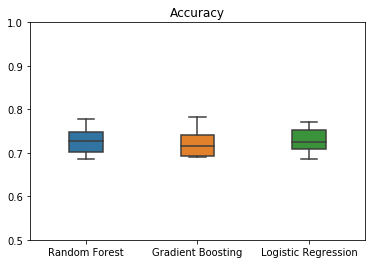

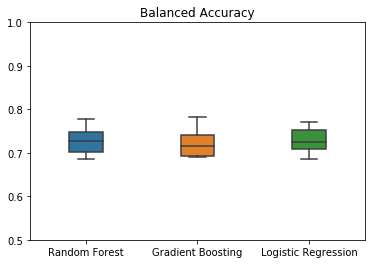

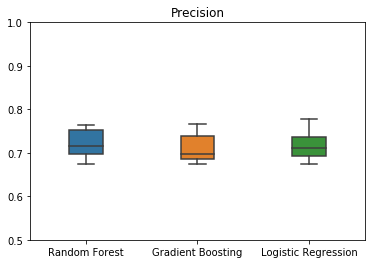

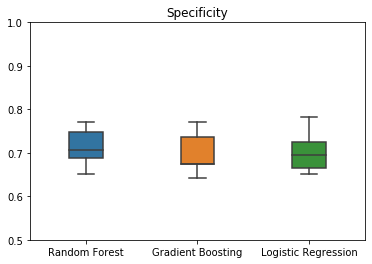

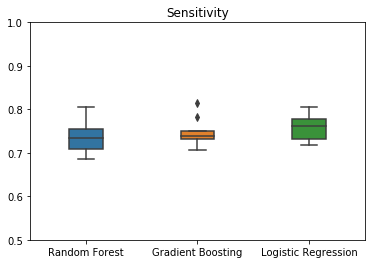

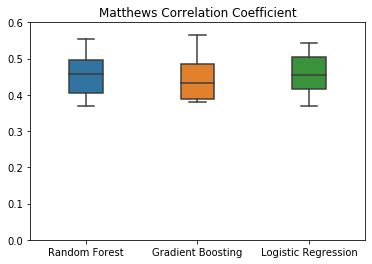

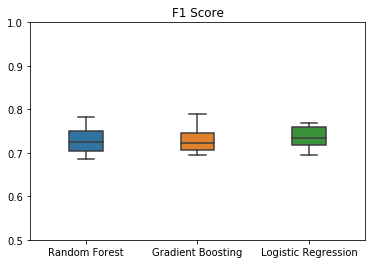

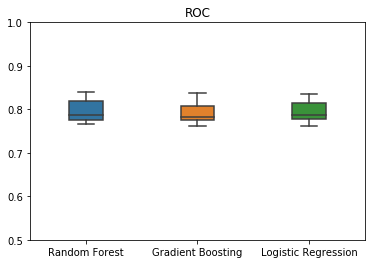

In [44]:
rf_acc = rf_nested_scores_total['test_accuracy']
gb_acc = gb_nested_scores_total['test_accuracy']
lr_acc = lr_nested_scores_total['test_accuracy']
sns.boxplot(data = [rf_acc,gb_acc,lr_acc], width = 0.3).set_title("Accuracy")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_ba_acc = rf_nested_scores_total['test_balanced_acc']
gb_ba_acc = gb_nested_scores_total['test_balanced_acc']
lr_ba_acc = lr_nested_scores_total['test_balanced_acc']
sns.boxplot(data = [rf_ba_acc,gb_ba_acc,lr_ba_acc], width = 0.3).set_title("Balanced Accuracy")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_precision = rf_nested_scores_total['test_precision']
gb_precision = gb_nested_scores_total['test_precision']
lr_precision = lr_nested_scores_total['test_precision']
sns.boxplot(data = [rf_precision,gb_precision,lr_precision], width = 0.3).set_title("Precision")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_spec = rf_nested_scores_total['test_specificity']
gb_spec = gb_nested_scores_total['test_specificity']
lr_spec = lr_nested_scores_total['test_specificity']
sns.boxplot(data = [rf_spec,gb_spec,lr_spec], width = 0.3).set_title("Specificity")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_sens = rf_nested_scores_total['test_sensitivity']
gb_sens = gb_nested_scores_total['test_sensitivity']
lr_sens = lr_nested_scores_total['test_sensitivity']
sns.boxplot(data = [rf_sens,gb_sens,lr_sens], width = 0.3).set_title("Sensitivity")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_mcc = rf_nested_scores_total['test_MCC']
gb_mcc = gb_nested_scores_total['test_MCC']
lr_mcc = lr_nested_scores_total['test_MCC']
sns.boxplot(data = [rf_mcc,gb_mcc,lr_mcc], width = 0.3).set_title("Matthews Correlation Coefficient")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0,0.6)
plt.show()

rf_f1 = rf_nested_scores_total['test_f1_score']
gb_f1 = gb_nested_scores_total['test_f1_score']
lr_f1 = lr_nested_scores_total['test_f1_score']
sns.boxplot(data = [rf_f1,gb_f1,lr_f1], width = 0.3).set_title("F1 Score")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_roc = rf_nested_scores_total['test_roc']
gb_roc = gb_nested_scores_total['test_roc']
lr_roc = lr_nested_scores_total['test_roc']
sns.boxplot(data = [rf_roc,gb_roc,lr_roc], width = 0.3).set_title("ROC")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

In [68]:
feat_names = nacc_data.filter(items = ["BILLS","TAXES","SHOPPING","GAMES","STOVE","MEALPREP","EVENTS","PAYATTN",
                                  "REMDATES","TRAVEL"]).columns
mci = nacc_data.loc[nacc_data['NACCUDSD'] == "MCI"]
ad = nacc_data.loc[nacc_data['NACCUDSD'] == "AD"]
for i in feat_names:
    print(i)
    stat, p = wilcoxon(mci[i], ad[i])
    print('Statistics=%.3f, p=%.20f' % (stat, p))

BILLS
Statistics=6244.500, p=0.00000000000000000000
TAXES
Statistics=5561.500, p=0.00000000000000000000
SHOPPING
Statistics=8333.000, p=0.00000000000000000000
GAMES
Statistics=9435.500, p=0.00000000000000000000
STOVE
Statistics=5806.000, p=0.00000000000000000000
MEALPREP
Statistics=8418.500, p=0.00000000000000000000
EVENTS
Statistics=14311.500, p=0.00000000000000000000
PAYATTN
Statistics=11462.000, p=0.00000000000000000000
REMDATES
Statistics=18060.000, p=0.00000000000000000000
TRAVEL
Statistics=8209.500, p=0.00000000000000000000


In [78]:
feat_names = nacc_data.filter(items = ["BILLS","TAXES","SHOPPING","GAMES","STOVE","MEALPREP","EVENTS","PAYATTN",
                                  "REMDATES","TRAVEL"]).columns
mci = nacc_data.loc[nacc_data['NACCUDSD'] == "MCI"]
ad = nacc_data.loc[nacc_data['NACCUDSD'] == "AD"]
p_vals = []
for i in feat_names:
    stat, p = wilcoxon(mci[i], ad[i])
    p_vals.append(p)
    
p_val_corrected = multitest.multipletests(p_vals, method='fdr_bh')
p_val_corrected[1]

for i in range(0,len(feat_names)):
    print(feat_names[i], p_val_corrected[1][i])

BILLS 5.40199457948644e-88
TAXES 5.108023378179379e-88
SHOPPING 1.403075385251665e-79
GAMES 1.16876305891418e-59
STOVE 5.255899628648929e-42
MEALPREP 7.069368120458183e-72
EVENTS 7.18714980082843e-68
PAYATTN 1.238346050364257e-57
REMDATES 1.4043170546355733e-72
TRAVEL 2.5787837459230145e-81
